## FEATURE IMPORTANCE & SELECTION

CONTEXT 

with 400+ features, not all contribute meaningfully to predictions. this will be a baseline model to estimate feature importance, enabling informed decision about which features to keep , drop , or engginer further

objective 
- train a quick LightGBM Model for importance estimation
- identify zero importance and low improtance features
- select top N features for downstream modeling
- save the feature importance ranking for reference

In [1]:
#import and load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

data_path = Path('../data/processed/train_features.parquet')
if not data_path.exists():
    data_path = Path('../data/interim/train_merged.parquet')

train = pd.read_parquet(data_path)
print(f'Data loaded: {train.shape}')

Data loaded: (590540, 434)


In [2]:
# prepare features

exclude_cols = ['TransactionID', 'isFraud', 'TransactionDT']
object_cols = train.select_dtypes(include=['object']).columns.to_list()

feature_cols = [c for c in train.columns if c not in exclude_cols and c not in object_cols]

X = train[feature_cols]
y = train['isFraud']

# TRAIN / VALIDAITON SPLIT
X_train, X_val,  y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

print(f"feature : {len(feature_cols)}")
print(f'target : {y.sum():,} fraud / {len(y):,} total ({y.mean()*100:.2f}%)')

feature : 431
target : 20,663 fraud / 590,540 total (3.50%)


## DATA SPLIT STRATEGY 
-  statrtified  split preserves fraud proportion (3.5%) in both train and val
- 80/20 split provides reliable importane estimation
- Object columns excluded as LightGBM requires encoding first

In [3]:
# lightGBM for importance

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1,
    'random_state': 42
    }

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# train with early stopping
evals_result = {}
model = lgb.train(
    params, 
    lgb_train, 
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=30),
        lgb.log_evaluation(period=20),
        lgb.record_evaluation(evals_result)
    ]
)

# calculate AUC
y_pred = model.predict(X_val)
val_auc = roc_auc_score(y_val, y_pred)

print(f'\nbest iteration : {model.best_iteration}')
print(f'Validation AUC : {val_auc:.4f}')

Training until validation scores don't improve for 30 rounds
[20]	train's auc: 0.896497	valid's auc: 0.889473
[40]	train's auc: 0.917003	valid's auc: 0.906934
[60]	train's auc: 0.928702	valid's auc: 0.917373
[80]	train's auc: 0.937354	valid's auc: 0.925577
[100]	train's auc: 0.944964	valid's auc: 0.931973
[120]	train's auc: 0.948838	valid's auc: 0.934432
[140]	train's auc: 0.953364	valid's auc: 0.937579
[160]	train's auc: 0.956967	valid's auc: 0.939506
[180]	train's auc: 0.961267	valid's auc: 0.942165
[200]	train's auc: 0.964285	valid's auc: 0.944098
Did not meet early stopping. Best iteration is:
[200]	train's auc: 0.964285	valid's auc: 0.944098

best iteration : 200
Validation AUC : 0.9441


## model performance 
- AUC 0.93-0.95 Indicates strong baseline model performance 
- early stoping prevents overfitting by moniotring validation score
- not the final model. only used to estimeated feature importance
- default LightGMB parametes already yield good result

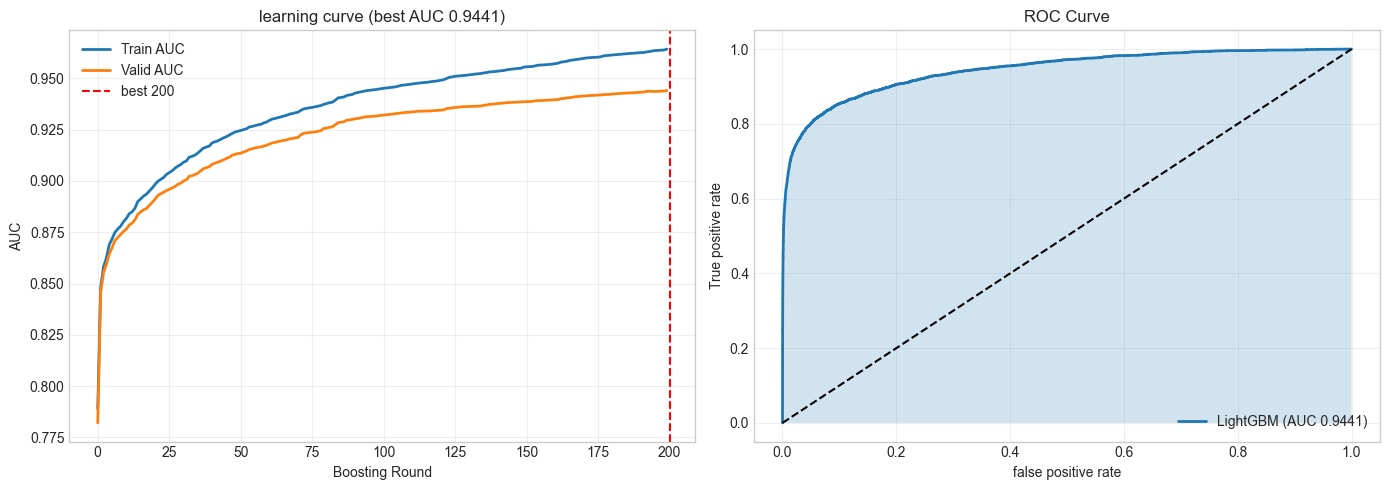

In [4]:
# visualize
fig,axes = plt.subplots(1,2, figsize=(14,5))

axes[0].plot(evals_result['train']['auc'], label='Train AUC', linewidth=2)
axes[0].plot(evals_result['valid']['auc'], label='Valid AUC', linewidth=2)
axes[0].axvline(x=model.best_iteration, color='r', linestyle='--', label=f'best {model.best_iteration}')
axes[0].set_xlabel("Boosting Round")
axes[0].set_ylabel('AUC')
axes[0].set_title(f'learning curve (best AUC {val_auc:.4f})')
axes[0].legend()
axes[0].grid(alpha=0.3)

fpr, tpr, _ = roc_curve(y_val, y_pred)
axes[1].plot(fpr, tpr, linewidth=2, label=f'LightGBM (AUC {val_auc:.4f})')
axes[1].plot([0,1], [0,1], 'k--')
axes[1].fill_between(fpr, tpr, alpha=0.2)
axes[1].set_xlabel('false positive rate') 
axes[1].set_ylabel('True positive rate') 
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## training dynamic
- small gap between train and valid AUC = no severe overfitting
- model convereges quickly ( <200 iterations)
- roc curve shows strong discriminative power

In [5]:
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print(f'Top 20 Features:')
print(importance.head(20).to_string(index=False))

Top 20 Features:
       feature   importance
          V258 47797.901000
            C1 22747.529584
    DeviceInfo 21567.054163
           C13 18921.583020
          V201 12640.845215
 R_emaildomain 12605.304462
           C14 11127.336526
         card2 10688.292346
          V294  8966.660742
TransactionAmt  8403.822078
            D2  7650.680259
         card1  7491.371001
         id_31  7371.311754
            C7  7199.960391
          V156  6520.822905
 P_emaildomain  6485.836023
         addr1  6471.912341
           C11  5694.898059
           D15  5543.493004
         card6  4648.715577


- gain importance measures average feature contribution during splits
- top features typically : TransactionAMT, card feature, C/V/D columns
- many v columns rank high as they are engginered for fraud detection
- featues with ~0 importance can be dropped for efficiency

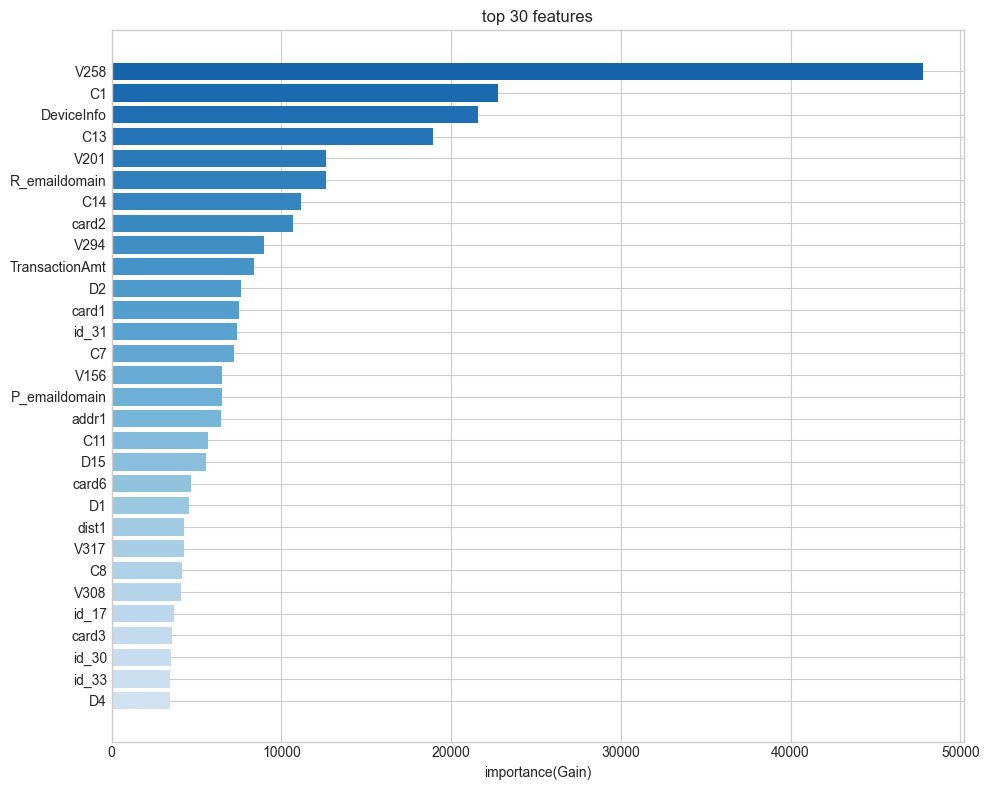

In [6]:
# visualize 
fig, ax = plt.subplots(figsize=(10,8))
top30 = importance.head(30)
ax.barh(range(30),
        top30['importance'].values,
        color=plt.cm.Blues(np.linspace(0.8,0.2,30)))
ax.set_yticks(range(30))
ax.set_yticklabels(top30['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('importance(Gain)')
ax.set_title('top 30 features')
plt.tight_layout()
plt.show()

### Insight: Top Features Pattern
- **V258 dominates** - Vesta's engineered feature is by far the most important, suggesting their proprietary risk signals are critical for fraud detection
- **Card behavior trumps raw amounts** - Aggregated card statistics (card1_amt_mean, card1_count, card1_amt_std) outperform raw TransactionAmt, showing fraudsters have distinctive spending patterns
- **Identity verification matters** - DeviceInfo and email domains (R_emaildomain, P_emaildomain) are top signals; fraudsters use suspicious devices/email providers
- **V-features are goldust** - Multiple V-columns (V258, V201, V317, V257, V156) scattered throughout show Vesta's feature engineering captured different fraud dimensions
- **Counting behavior works** - C-columns (C1, C14, C13, C11, C7) prove that counting events/transactions in time windows catches anomalous patterns
- **ID features add value** - Identity fields (id_31, id_33, id_30) linking transactions to verification help distinguish legitimate users from fraudsters

In [7]:
TOP_N = 200
selected_features = importance.head(TOP_N)['feature'].tolist()

output_path = Path('../data/metadata')
output_path.mkdir(parents=True, exist_ok=True)
importance.to_csv(output_path / 'feature_importance.csv', index=False)

print({output_path})

{WindowsPath('../data/metadata')}
